#  Assignment-2B-Task3_streaming_application: Streaming application using Spark Structured Streaming (40%)
Name : Pichaphop Sunthornjittanon

Student ID : 31258301

In this task, we will implement Spark Structured Streaming to consume the data from task
1 and perform streaming classification.


Important:

● You may use Spark Structured Streaming together with Spark SQL and ML.

● You are also provided with a set of pre-trained pipeline models to classify the
binary classification flight-delays (to be provided soon).

Write a python program that achieves the following requirements. Save the file as
Assignment-2B-Task3_streaming_application.ipynb.

1. SparkSession is created using a SparkConf object, which would use two local cores
with a proper application name, and use UTC as the timezone 3.

2. From the Kafka producers in Task 1, ingest the streaming data into Spark Streaming.

3. Then the streaming data format should be transformed into the proper formats
following the file schema in the metadata.

4. Persist the transformed streaming data in parquet format for flight data. Flight data
should be stored in “flight.parquet” in the same folder of your notebook.

5. Load the machine learning models given, and use the models to classify whether each
flight records are delayed. This is based on the assumption that the data has been
labelled.

6. Using the classification results, monitor the data following the requirements below.
For each key in keyFlight = ‘1’, keyFlight = ‘2’, and keyFlight = ‘3’, keep track of
the accumulated accuracy for every timestamp in the 2-min window for a total of 6
minutes.

i. Your results should include, number of records flight and for each key,
including their accumulated accuracy in each timestamp.

ii. Visualise the data in line charts. Prepare a line chart plot to show the
number of flights from the start to the most recent.
For this visualisation, You need two subplots. First subplot, the x-axis
can be used to represent the timestamp, while y-axis can be used to
represent the number of countFlightRecords. For the second subplot,
x-axis can be used to represent the timestamp, whereas y-axis can be
used to plot the accumMeanAccuracy. For each subplot, the results
from all keyFlights (key = ‘1’, key = ‘2’, and key = ‘3’) should be
represented in different color legends.

### 1. SparkSession is created using a SparkConf object
which would use two local cores with a proper application name, and use UTC as the timezone 3

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark import SparkConf

# Use two local cores
master = "local[2]"

# Name the application
app_name = "Flight Data Streaming Application"

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)


spark = SparkSession.builder.config(conf = spark_conf)\
            .config('spark.sql.session.timeZone', 'UTC')\
              .getOrCreate()



### 2.From the Kafka producers in Task 1, ingest the streaming data into Spark Streaming


In [2]:
topic = "flightTopic"
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic) \
    .load()

### 3. Then the streaming data format should be transformed into the proper formats following the file schema in the metadata
Converting the key/value from the kafka data stream to string

In [3]:
df = df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")


Convert the incoming stream into dataframe based on the schema. Note that, were are receiving a list from the producer, so the schema and other transformations are done accordingly

In [4]:
# Create schema (All datatype to string b/c we have to deal with missing data)
schema = ArrayType(StructType([    
    StructField('YEAR', StringType(), True), 
    StructField('MONTH', StringType(), True),
    StructField('DAY', StringType(), True),
    StructField('DAY_OF_WEEK', StringType(), True),
    StructField('AIRLINE', StringType(), True),
    StructField('FLIGHT_NUMBER', StringType(), True),
    StructField('TAIL_NUMBER', StringType(), True),
    StructField('ORIGIN_AIRPORT', StringType(), True),
    StructField('DESTINATION_AIRPORT', StringType(), True),
    StructField('SCHEDULED_DEPARTURE', StringType(), True),
    StructField('DEPARTURE_TIME', StringType(), True),
    StructField('DEPARTURE_DELAY', StringType(), True),
    StructField('TAXI_OUT', StringType(), True),
    StructField('WHEELS_OFF', StringType(), True),
    StructField('SCHEDULED_TIME', StringType(), True),
    StructField('ELAPSED_TIME', StringType(), True),
    StructField('AIR_TIME', StringType(), True),
    StructField('DISTANCE', StringType(), True),
    StructField('WHEELS_ON', StringType(), True),
    StructField('TAXI_IN', StringType(), True),
    StructField('SCHEDULED_ARRIVAL', StringType(), True),
    StructField('ARRIVAL_TIME', StringType(), True),
    StructField('ARRIVAL_DELAY', StringType(), True),
    StructField('DIVERTED', StringType(), True),
    StructField('CANCELLED', StringType(), True),
    StructField('CANCELLATION_REASON', StringType(), True),
    StructField('AIR_SYSTEM_DELAY', StringType(), True),
    StructField('SECURITY_DELAY', StringType(), True),
    StructField('AIRLINE_DELAY', StringType(), True),
    StructField('LATE_AIRCRAFT_DELAY', StringType(), True),
    StructField('WEATHER_DELAY', StringType(), True),
    StructField('ts', TimestampType(), True)            
]))

In [5]:
df=df.select(F.from_json(F.col("value").cast("string"), schema).alias('parsed_value'))

In [6]:
df = df.select(F.explode(F.col("parsed_value")).alias('unnested_value'))      

In [7]:
df_formatted = df.select(
    F.col('unnested_value.YEAR').alias("YEAR"), 
    F.col('unnested_value.MONTH').alias("MONTH"),
    F.col('unnested_value.DAY').alias("DAY"),
    F.col('unnested_value.DAY_OF_WEEK').alias("DAY_OF_WEEK"),
    F.col('unnested_value.AIRLINE').alias("AIRLINE"),
    F.col('unnested_value.FLIGHT_NUMBER').alias("FLIGHT_NUMBER"),
    F.col('unnested_value.TAIL_NUMBER').alias("TAIL_NUMBER"),
    F.col('unnested_value.ORIGIN_AIRPORT').alias("ORIGIN_AIRPORT"),
    F.col('unnested_value.DESTINATION_AIRPORT').alias("DESTINATION_AIRPORT"),
    F.col('unnested_value.SCHEDULED_DEPARTURE').alias("SCHEDULED_DEPARTURE"),
    F.col('unnested_value.DEPARTURE_TIME').alias("DEPARTURE_TIME"),
    F.col('unnested_value.DEPARTURE_DELAY').alias("DEPARTURE_DELAY"),
    F.col('unnested_value.TAXI_OUT').alias("TAXI_OUT"),
    F.col('unnested_value.WHEELS_OFF').alias("WHEELS_OFF"),
    F.col('unnested_value.SCHEDULED_TIME').alias("SCHEDULED_TIME"),
    F.col('unnested_value.ELAPSED_TIME').alias("ELAPSED_TIME"),
    F.col('unnested_value.AIR_TIME').alias("AIR_TIME"),
    F.col('unnested_value.DISTANCE').alias("DISTANCE"),
    F.col('unnested_value.WHEELS_ON').alias("WHEELS_ON"),
    F.col('unnested_value.TAXI_IN').alias("TAXI_IN"),
    F.col('unnested_value.SCHEDULED_ARRIVAL').alias("SCHEDULED_ARRIVAL"),
    F.col('unnested_value.ARRIVAL_TIME').alias("ARRIVAL_TIME"),
    F.col('unnested_value.ARRIVAL_DELAY').alias("ARRIVAL_DELAY"),
    F.col('unnested_value.DIVERTED').alias("DIVERTED"),
    F.col('unnested_value.CANCELLED').alias("CANCELLED"),
    F.col('unnested_value.CANCELLATION_REASON').alias("CANCELLATION_REASON"),
    F.col('unnested_value.AIR_SYSTEM_DELAY').alias("AIR_SYSTEM_DELAY"),
    F.col('unnested_value.SECURITY_DELAY').alias("SECURITY_DELAY"),
    F.col('unnested_value.AIRLINE_DELAY').alias("AIRLINE_DELAY"),
    F.col('unnested_value.LATE_AIRCRAFT_DELAY').alias("LATE_AIRCRAFT_DELAY"),
    F.col('unnested_value.WEATHER_DELAY').alias("WEATHER_DELAY"),
    F.col('unnested_value.ts').alias("ts")  
                )

In [8]:
# Convert datatypes specified in the metadata
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

df_formatted=df_formatted.withColumn("YEAR",col("YEAR").cast(IntegerType())).\
             withColumn("MONTH",col("MONTH").cast(IntegerType())).\
             withColumn("DAY",col("DAY").cast(IntegerType())).\
             withColumn("DAY_OF_WEEK",col("DAY_OF_WEEK").cast(IntegerType())).\
             withColumn("DAY_OF_WEEK",col("DAY_OF_WEEK").cast(IntegerType())).\
             withColumn("FLIGHT_NUMBER",col("FLIGHT_NUMBER").cast(IntegerType())).\
             withColumn("SCHEDULED_DEPARTURE",col("SCHEDULED_DEPARTURE").cast(IntegerType())).\
             withColumn("DEPARTURE_TIME",col("DEPARTURE_TIME").cast(IntegerType())).\
             withColumn("DEPARTURE_DELAY",col("DEPARTURE_DELAY").cast(IntegerType())).\
             withColumn("TAXI_OUT",col("TAXI_OUT").cast(IntegerType())).\
             withColumn("WHEELS_OFF",col("WHEELS_OFF").cast(IntegerType())).\
             withColumn("SCHEDULED_TIME",col("SCHEDULED_TIME").cast(IntegerType())).\
             withColumn("ELAPSED_TIME",col("ELAPSED_TIME").cast(IntegerType())).\
             withColumn("AIR_TIME",col("AIR_TIME").cast(IntegerType())).\
             withColumn("DISTANCE",col("DISTANCE").cast(IntegerType())).\
             withColumn("WHEELS_ON",col("WHEELS_ON").cast(IntegerType())).\
             withColumn("TAXI_IN",col("TAXI_IN").cast(IntegerType())).\
             withColumn("SCHEDULED_ARRIVAL",col("SCHEDULED_ARRIVAL").cast(IntegerType())).\
             withColumn("ARRIVAL_TIME",col("ARRIVAL_TIME").cast(IntegerType())).\
             withColumn("ARRIVAL_DELAY",col("ARRIVAL_DELAY").cast(IntegerType())).\
             withColumn("DIVERTED",col("DIVERTED").cast(IntegerType())).\
             withColumn("AIR_SYSTEM_DELAY",col("AIR_SYSTEM_DELAY").cast(IntegerType())).\
             withColumn("SECURITY_DELAY",col("AIR_SYSTEM_DELAY").cast(IntegerType())).\
             withColumn("AIRLINE_DELAY",col("AIR_SYSTEM_DELAY").cast(IntegerType())).\
             withColumn("LATE_AIRCRAFT_DELAY",col("AIR_SYSTEM_DELAY").cast(IntegerType())).\
             withColumn("WEATHER_DELAY",col("AIR_SYSTEM_DELAY").cast(IntegerType()))

In [9]:
# Print schema
df_formatted.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

### 4. Persist the transformed streaming data in parquet format for flight data. Flight data should be stored in “flight.parquet” in the same folder of your notebook

In [10]:
# Write into parquet files 
query_file_sink = df_formatted.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "parquet/flight.parquet")\
        .option("checkpointLocation", "parquet/flight.parquet/checkpoint")\
        .start()

In [11]:
# Read the saved parquet data
query_file_sink_df = spark.read.parquet("parquet/flight.parquet")
query_file_sink_df.printSchema()
query_file_sink_df.show()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

### 5. Load the machine learning models given, 
and use the models to classify whether each flight records are delayed. This is based on the assumption that the data has been labelled. (Use the model from assignment 2)

In [12]:
### Load the machine learning 

from pyspark.ml.pipeline import PipelineModel
gbt_arr_model = PipelineModel.load('gbt_arr_model')

### 6.Using the classification results, 

monitor the data following the requirements below. For each key in keyFlight = ‘1’, keyFlight = ‘2’, and keyFlight = ‘3’, keep track of the accumulated accuracy for every timestamp in the 2-min window for a total of 6 minutes.

In [13]:
########## 6.1 Feature Engineer for streaming data ##########
import pyspark.sql.functions as F
import pyspark.sql.functions as f
from pyspark.sql.functions import when

# Remove columns that contains high number of null value
removedColumns =['CANCELLATION_REASON',
 'WEATHER_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'AIRLINE_DELAY',
 'SECURITY_DELAY',
 'AIR_SYSTEM_DELAY']

# Create function that flightsRawDf is updated by removing columns
def eliminate_columns(removedColumns, flightsRawDf):
    
    # Create the list of remaining column by removing columns in removedColumns
    keepColumns= [col for col in flightsRawDf.columns if col not in removedColumns]
    
    # Exclude the column that is in the removedColumns list
    flightsRawDf = flightsRawDf.select(keepColumns)
    
    # Return the flightsRawDf
    return flightsRawDf

# Eliminate the columns

flights_streaming = eliminate_columns(removedColumns, df_formatted)

#  Drop rows with Null and Nan values from flightsRawDf.
flights_streaming = flights_streaming.dropna()

# Add the new column binaryArrDelay
flights_streaming = flights_streaming.withColumn('binaryArrDelay',
                            f.when((f.col('ARRIVAL_DELAY') > 0), 1)\
                              .otherwise(0))

# ### 1. Time data (SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL) ###

# # 1.1 Change data type to string in order to do lpad
flights_streaming= flights_streaming.withColumn("SCHEDULED_DEPARTURE", 
                                flights_streaming["SCHEDULED_DEPARTURE"].cast("string"))\
            .withColumn("SCHEDULED_ARRIVAL", flights_streaming["SCHEDULED_ARRIVAL"].cast("string"))

# # 1.2 Use lpad to fill 0            
flights_streaming= flights_streaming.withColumn("SCHEDULED_DEPARTURE",
                                F.lpad(flights_streaming["SCHEDULED_DEPARTURE"], 4, '0'))\
    .withColumn("SCHEDULED_DEPARTURE_HOUR",F.substring('SCHEDULED_DEPARTURE',1,2))\
    .withColumn("SCHEDULED_ARRIVAL",F.lpad(flights_streaming["SCHEDULED_ARRIVAL"], 4, '0'))\
    .withColumn("SCHEDULED_ARRIVAL_HOUR",F.substring('SCHEDULED_ARRIVAL',1,2))\

# # 1.3 Extract hours
flights_streaming= flights_streaming.withColumn("SCHEDULED_DEPARTURE_HOUR",
                                flights_streaming["SCHEDULED_DEPARTURE_HOUR"].cast("integer"))

flights_streaming= flights_streaming.withColumn("SCHEDULED_ARRIVAL_HOUR",
                                flights_streaming["SCHEDULED_ARRIVAL_HOUR"].cast("integer"))

# # 1.4 Create dayparts feature
flights_streaming= flights_streaming.withColumn('SCHEDULED_DEPARTURE_daypart',
               when((col('SCHEDULED_DEPARTURE_HOUR') >= 2) & 
                    (col('SCHEDULED_DEPARTURE_HOUR') <= 5), "dawn")\
             .when((col('SCHEDULED_DEPARTURE_HOUR') >= 6) &
                   (col('SCHEDULED_DEPARTURE_HOUR') <= 9), "morning")\
             .when((col('SCHEDULED_DEPARTURE_HOUR') >= 10) & 
                   (col('SCHEDULED_DEPARTURE_HOUR') <= 13), "noon")\
             .when((col('SCHEDULED_DEPARTURE_HOUR') >= 14) & 
                   (col('SCHEDULED_DEPARTURE_HOUR') <= 17), "afternoon")\
             .when((col('SCHEDULED_DEPARTURE_HOUR') >= 18) & 
                   (col('SCHEDULED_DEPARTURE_HOUR') <= 21), "evening")\
             .otherwise("midnight"))\
    .withColumn('SCHEDULED_ARRIVAL_daypart',
                   when((col('SCHEDULED_ARRIVAL_HOUR') >= 2) &
                        (col('SCHEDULED_ARRIVAL_HOUR') <= 5), "dawn")\
                 .when((col('SCHEDULED_ARRIVAL_HOUR') >= 6) & 
                       (col('SCHEDULED_ARRIVAL_HOUR') <= 9), "morning")\
                 .when((col('SCHEDULED_ARRIVAL_HOUR') >= 10) & 
                       (col('SCHEDULED_ARRIVAL_HOUR') <= 13), "noon")\
                 .when((col('SCHEDULED_ARRIVAL_HOUR') >= 14) & 
                       (col('SCHEDULED_ARRIVAL_HOUR') <= 17), "afternoon")\
                 .when((col('SCHEDULED_ARRIVAL_HOUR') >= 18) & 
                       (col('SCHEDULED_ARRIVAL_HOUR') <= 21), "evening")\
                 .otherwise("midnight"))

# ### 2. Month data (create season feature) ###

flights_streaming= flights_streaming.withColumn('SEASON',when((col('MONTH') >= 3) & (col('MONTH') <= 5),'Spring')\
                             .when((col('MONTH') >= 6) & (col('MONTH') <= 8),'Summer')\
                             .when((col('MONTH') >= 9) & (col('MONTH') <= 11),'Autumn')\
                             .otherwise('Winter'))

# ### 3. day of week data (create is_weekend feature) ###

flights_streaming= flights_streaming.withColumn('is_weekend',
                                when((col('DAY_OF_WEEK') == 6) | (col('DAY_OF_WEEK') == 7),1)\
                             .otherwise(0))

# # Select columns after excluding and including some columns
include_features = ['MONTH','DAY','DAY_OF_WEEK','AIRLINE',
                 'SCHEDULED_ARRIVAL_HOUR','SCHEDULED_TIME','DISTANCE','SCHEDULED_DEPARTURE_HOUR',
                 'SEASON','is_weekend','SCHEDULED_DEPARTURE_daypart','SCHEDULED_ARRIVAL_daypart',
                    'binaryArrDelay','ts']

flights_streaming = flights_streaming[include_features]



In [14]:
########## 6.2 Predict the label in streaming data and do some data aggregration ##########

# Predict the label
gbt_arr_prediction = gbt_arr_model.transform(flights_streaming)

# Flag the record whether they are correctly predicted or not 
gbt_arr_prediction =gbt_arr_prediction.withColumn('correct_prediction',
                            f.when((f.col('binaryArrDelay') == f.col('prediction')), 1)\
                              .otherwise(0))
#Group by ts window,day of week to get number of record and sum of correct_prediction
grouped_gbt_arr = gbt_arr_prediction.groupBy([F.window("ts","120 second","10 second"),"DAY_OF_WEEK"])\
                    .agg(F.count("MONTH").alias("number_of_record"),F.sum("correct_prediction").alias("number_of_correct"))

#Generate accuracy column
grouped_gbt_arr = grouped_gbt_arr.withColumn('Accuracy',f.col('number_of_correct')/f.col('number_of_record'))

#Select relavant column for ploting
grouped_gbt_arr = grouped_gbt_arr.select(
                    F.col("DAY_OF_WEEK"),              
                    F.col("window.end").alias("end_time"),
                    F.col("number_of_record"),
                    F.col("Accuracy")
                )
#Write stream in member of the query name groupby_ts_dow
query_reduce = grouped_gbt_arr \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("groupby_ts_dow") \
    .start()

#Write stream in member of the query name flights_streaming
query_full = gbt_arr_prediction \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("flights_streaming")\
    .start()

In [15]:
# Define initialse plot function
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)

        ax1 = fig.add_subplot(311)
        ax2 = fig.add_subplot(312)
        ax3 = fig.add_subplot(313)
        
        ax1.set_xlabel('Time (last 6 minute )')
        ax1.set_ylabel('countFlightRecords')
        ax1.title.set_text('countFlightRecords (window size = 2 min, time-slide = 10 seconds) for last 6 minutes')
     
        ax2.set_xlabel('Time (last 6 minute )')
        ax2.set_ylabel('Accuracy')
        ax2.title.set_text('Accuracy (window size = 2 min, time-slide = 10 seconds) for last 6 minutes')
        
        ax3.set_xlabel('Time (last 6 minute )')
        ax3.set_ylabel('accumMeanAccuracy')

   
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax1, ax2, ax3
    except Exception as ex:
        print(str(ex))

i. Your results should include, number of records flight and for each key,
including their accumulated accuracy in each timestamp.

ii. Visualise the data in line charts. Prepare a line chart plot to show the
number of flights from the start to the most recent.
For this visualisation, You need two subplots. First subplot, the x-axis
can be used to represent the timestamp, while y-axis can be used to
represent the number of countFlightRecords. For the second subplot,
x-axis can be used to represent the timestamp, whereas y-axis can be
used to plot the accumMeanAccuracy. For each subplot, the results
from all keyFlights (key = ‘1’, key = ‘2’, and key = ‘3’) should be
represented in different color legends.

<IPython.core.display.Javascript object>


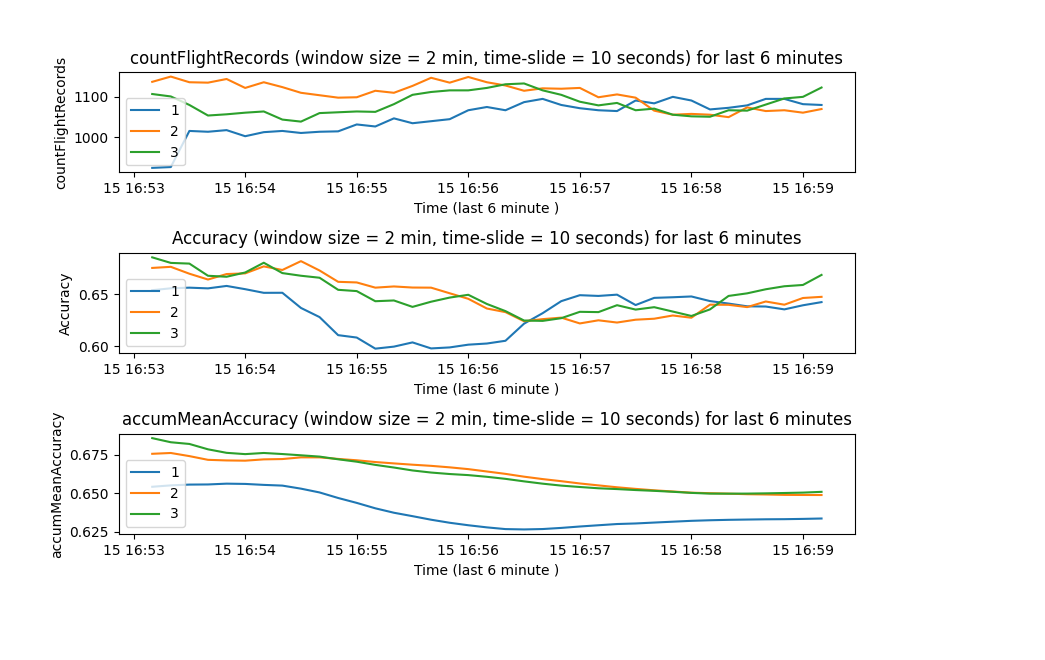

KeyboardInterrupt: 

In [16]:
############# II PLoting the results (line graph format) #############
import time
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np

%matplotlib notebook

fig, ax1, ax2, ax3 = init_plots()


while True:
    
    # select data from groupby_ts_dow where day_of_week in (1,2,3) order by end time
    df_reduced = spark.sql("select * from groupby_ts_dow where day_of_week in (1,2,3) order by end_time").toPandas()
    
    # Set min and max time that we want to show in the graph (last 6 min)
    # (for max time we minus 2 minute on end time becase we want full data at end time 
    
    min_time = df_reduced['end_time'].max()- datetime.timedelta(minutes=8)
    max_time = df_reduced['end_time'].max()- datetime.timedelta(minutes=2)
    
    # Data in last 6 minutes with window aggreagration
    df_reduced =df_reduced[(df_reduced['end_time'] >= min_time) & (df_reduced['end_time'] <= max_time )]
    

    # Clear axis
    ax1.clear()
    # For each keyFlight
    for keyFlight in [1,2,3]:

        # Plot each line for each keyFlight where X axis = TS Window, Y = countFlightRecords
        ax1.plot(df_reduced[df_reduced.DAY_OF_WEEK==keyFlight].end_time.to_list()
                ,df_reduced[df_reduced.DAY_OF_WEEK==keyFlight].number_of_record.to_list()
                ,label=keyFlight)
        
    ax1.set_xlabel('Time (last 6 minute )')
    ax1.set_ylabel('countFlightRecords')
    ax1.title.set_text('countFlightRecords (window size = 2 min, time-slide = 10 seconds) for last 6 minutes')
    leg = ax1.legend()
    
    # Clear axis
    ax2.clear()
    # For each keyFlight
    for keyFlight in [1,2,3]:

        # Plot each line for each keyFlight where X axis = TS Window, Y = Accuracy
        ax2.plot(df_reduced[df_reduced.DAY_OF_WEEK==keyFlight].end_time.to_list()
                ,df_reduced[df_reduced.DAY_OF_WEEK==keyFlight].Accuracy.to_list()
                ,label=keyFlight)
    ax2.set_xlabel('Time (last 6 minute )')
    ax2.set_ylabel('Accuracy')
    ax2.title.set_text('Accuracy (window size = 2 min, time-slide = 10 seconds) for last 6 minutes')
    leg = ax2.legend()
    # Clear axis
    ax3.clear()
    # For each keyFlight
    for keyFlight in [1,2,3]:
        
        # Find AccumMeanAccuracy and add to the dataframe
        each_key_df = df_reduced.loc[df_reduced.DAY_OF_WEEK==keyFlight].reset_index(drop =True)
        each_accuracy = each_key_df['Accuracy']
        each_key_df.loc[:,'AccumMeanAccuracy'] = each_accuracy.cumsum() / pd.Series(np.arange(1, len(each_accuracy)+1)
                                                       , each_accuracy.index)
        
        # Plot each line for each keyFlight where X axis = TS Window, Y = accumMeanAccuracy
        ax3.plot(each_key_df[each_key_df.DAY_OF_WEEK==keyFlight].end_time.to_list()
                ,each_key_df[each_key_df.DAY_OF_WEEK==keyFlight].AccumMeanAccuracy.to_list()
                ,label=keyFlight)
        
#         print(f'Key flight = {keyFlight}')
#         print(f'Minimum end time is {min_time}, Maximum end time is {max_time}')
#         print('The data is shown below')
#         print(each_key_df)
     
    ax3.set_xlabel('Time (last 6 minute )')
    ax3.set_ylabel('accumMeanAccuracy')
    ax3.title.set_text('accumMeanAccuracy (window size = 2 min, time-slide = 10 seconds) for last 6 minutes')
   
    leg = ax3.legend()
    fig.canvas.draw()
    

    time.sleep(5)

In [ ]:
############# I Printing the results( table format) #############
while True:    
    for keyFlight in [1,2,3]:
        
        # select data from groupby_ts_dow where day_of_week in (1,2,3) order by end time
        df_reduced = spark.sql("select * from groupby_ts_dow where day_of_week in (1,2,3) order by end_time").toPandas()

        # Set min and max time that we want to show in the graph (last 6 min)
        # (for max time we minus 2 minute on end time becase we want full data at end time 

        min_time = df_reduced['end_time'].max()- datetime.timedelta(minutes=8)
        max_time = df_reduced['end_time'].max()- datetime.timedelta(minutes=2)

        # Data in last 6 minutes with window aggreagration
        df_reduced =df_reduced[(df_reduced['end_time'] >= min_time) & (df_reduced['end_time'] <= max_time )]
        
        # Find AccumMeanAccuracy and add to the dataframe
        each_key_df = df_reduced.loc[df_reduced.DAY_OF_WEEK==keyFlight].reset_index(drop =True)
        each_accuracy = each_key_df['Accuracy']
        each_key_df.loc[:,'AccumMeanAccuracy'] = each_accuracy.cumsum() / pd.Series(np.arange(1, len(each_accuracy)+1)
                                                       , each_accuracy.index)    
        print(f'\nKey flight = {keyFlight}')
        print(f'Minimum end time is {min_time}, Maximum end time is {max_time}')
        print('The data is shown below\n')
        print(each_key_df)

In [ ]:
# query_reduce.stop()
# query_reduce.full()